In [1]:
import xarray as xr

import numpy as np

import scipy.stats as stats

import pandas as pd

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

import glob

import datetime

import matplotlib.pyplot as plt

import pickle

import cartopy.crs as ccrs

import cartopy.feature as cfeature

from scipy.stats import spearmanr

import seaborn as sns

import os

import matplotlib.colors as mcolors

from matplotlib.colors import TwoSlopeNorm

from sklearn.metrics import silhouette_score

from scipy.stats import pearsonr

from pathlib import Path

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import metpy.calc as mpcalc

from metpy.constants import Rd

from metpy.units import units

pd.options.mode.chained_assignment = None

In [ ]:
# Define the file paths where the data was saved

ctp_file_path = '/data/rong3/annie/completed_ctp_hilow_arrays/ctp_results.npz'

hi_file_path = '/data/rong3/annie/completed_ctp_hilow_arrays/hi_results.npz'

# Load the arrays from the .npz file
ctp_data = np.load(ctp_file_path)

hi_data = np.load(hi_file_path)

# Extract the arrays from the loaded data
ctp_results = ctp_data['ctp_results']

hi_results = hi_data['hi_results']

In [ ]:


# contains lists of CTP for every month-day

ctpdf = resultdf.groupby(['month', 'day'])['ctp'].agg(list).reset_index()

ctpdf['ctpz']= ""

for i in range(ctpdf.shape[0]):
    
    # extracts all CTPs for the month-day 
    
    x = np.array(ctpdf['ctp'][i])

    x = x.reshape(-1, 1)

    qt = QuantileTransformer(output_distribution='normal')
    
    xqt = qt.fit_transform(x)
    
    ctpdf['ctpz'][i] = xqt
    
#output of xqt puts every value in a list, this removes the inner lists

ctpdf['ctpz'] = ctpdf['ctpz'].apply(lambda x: [item for sublist in x for item in sublist])  

ctp_raw = ctpdf.explode('ctp').drop('ctpz', axis=1)

ctp_z = ctpdf.explode('ctpz').drop('ctp', axis=1)

ctpz = ctp_z['ctpz']

ctpdf = pd.concat([ctp_raw, ctpz], axis=1)

resultdf = resultdf.reset_index()

ctpdf = ctpdf.reset_index()

resultdf = pd.merge(resultdf, ctpdf[['month','day', 'ctp', 'ctpz']], on=['month', 'day', 'ctp'], how='left')

## preparing arrays 

In [2]:
data = np.load('backup_data/backup_arrays_for_buoyancy.npz')

# these are all interpolated to every 20 m

pressure = data['array1'] # Shape: (time, pressure_level, lat, lon)

q = data['array2'] # Shape: (time, pressure_level, lat, lon)

temperature = data['array3'] # Shape: (time, pressure_level, lat, lon) in K

qfit = data['array_4'] # Shape: (time, pressure_level, lat, lon)

altitude = np.arange(0, 4000 + 20, 20)

In [4]:
# calculating dewpoint from specific humidity 

# temp conversion to kelvin necessary for dewpoint calculation 

temperature = (temperature + 273.15) * units.K

pressure = pressure * units.hPa  

humidity = q * units('g/kg')

dewpoint = mpcalc.dewpoint_from_specific_humidity(pressure, temperature, humidity)

In [7]:
# temp conversion back to deg C necessary for cal_ctp_hi 

temperature = temperature.magnitude

temperature = (temperature - 273.15) * units.degC

In [13]:
# Remove the units (store only the raw values)

temperature_data = temperature.magnitude

dewpoint_data = dewpoint.magnitude

pressure_data = pressure.magnitude

altitude_data = altitude  # Altitude is likely just a regular array

# Create the directory if it doesn't exist
backup_data_dir = os.path.expanduser('~/backup_data')

os.makedirs(backup_data_dir, exist_ok=True)

# Define the file path
file_path = os.path.join(backup_data_dir, 'ctp_hilow_input_arrays.npz')

# Save the arrays into the .npz file
np.savez(file_path, temperature=temperature_data, dewpoint=dewpoint_data, pressure=pressure_data, altitude=altitude_data)

print(f"Data saved successfully to {file_path}")


Data saved successfully to /home/annierosen16/backup_data/ctp_hilow_input_arrays.npz


In [10]:
def cal_ctp_hi(temperature, dewpoint, pressure, altitude):
    
    '''
    INPUT:
        temperature 
        dewpoint
        pressure
        altitude 
    Note: all input should have metpy.units but altitude
    OUTPUT:
        ctp  : Convective Triggering Potential
        hi   : Humidity Index
        moist_t : Moist adiabatic temperature profile from 1km to 3km AGL
        cal_p   : Pressure profile from 1km to 3km AGL
    '''
    
    alt = altitude 
    
    start_index = np.where(alt == alt[0] + 1000)[0][0]
    
    end_index = np.where(alt == alt[0] + 3000)[0][0]
    
    cal_p = pressure[start_index:end_index + 1]
        
    cal_t = temperature[start_index:end_index + 1]
    
    # to interpolate observed pressure profile to 2 hpa increments
    
    p_level = np.arange(pressure[0].magnitude, pressure[-1].magnitude, -2) * units.hPa
    
    # calculates a moist temperature profile against synthetic pressure levels (p_level)
    
    # and using starting temperature and pressure as starting point
    
    moist_temp = mpcalc.moist_lapse(
        
        pressure=p_level, 
        
        temperature=cal_t[0], 
        
        reference_pressure=cal_p[0]
    
    ).to(units.degC)
    
    # cal_moist is segmented from moist_temp to 100 -> 300 hpa AGL
    
    cal_moist = np.interp(
        
        cal_p.magnitude[::-1],
        
        p_level.magnitude[::-1],
        
        moist_temp.magnitude[::-1]
    
    )[::-1] * moist_temp.units
        
    ctp = (Rd * (np.trapz(
        
        (cal_moist.magnitude - cal_t.magnitude)[::-1], 
        
        np.log(cal_p.magnitude)[::-1]
    
    ) * units.degK)).to(units('J/kg'))
    
    index0 = np.where(alt == alt[0] + 500)[0][0]
    
    index1 = np.where(alt == alt[0] + 1500)[0][0]
    
    hi = (temperature[index0] - dewpoint[index0] + 
          
          temperature[index1] - dewpoint[index1])
    
    print(temperature[index0] - dewpoint[index0],temperature[index1] - dewpoint[index1])
    
    return ctp.magnitude, hi.magnitude

360.2707270902161 J/kg


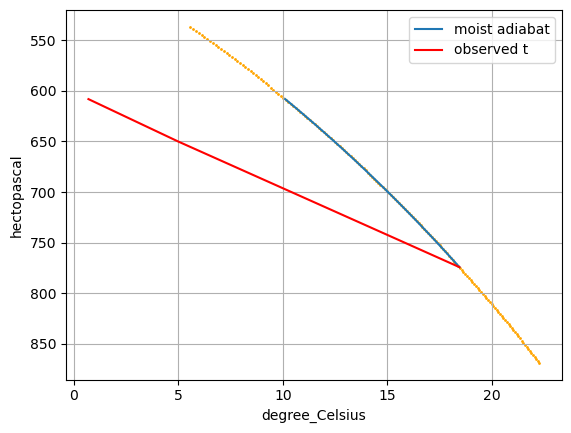

In [103]:
print(ctp, "J/kg")

plt.plot(cal_moist, cal_p, label='moist adiabat')

plt.plot(cal_t, cal_p, color='red', label='observed t')

plt.scatter(moist_temp, p_level, color='orange', s=1)

plt.gca().invert_yaxis()

plt.legend()

plt.grid()

plt.show()

50.4867851396765


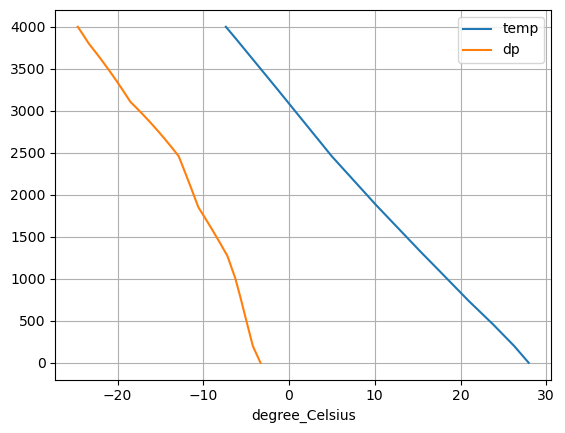

In [104]:
print(hi)

plt.plot(temperature_test, altitude, label='temp')

plt.plot(dewpoint_test, altitude, label='dp')

plt.legend()

plt.grid()

plt.show()